# Autophagy sample screen data

<b> Goal: <b> 

We want to retrain the binary classifier (0 == autophagy intact and 1 == autophagy not intact) on a small data subset containing 20% of all replicates and then using weights and biases (wandb) look at how the classifier fits, when it overfits, etc. 

<b> Raw data is here: <b> 

/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample 


<b> Image structure: <b> 

It has has 12 HDF5 files with 100k cell images each from a different biological replicate each. HDF5 structure is ["annotation", "single_cell_data", "single_cell_index"]  with single_cell_data containing the images. 
Images are 128 x 128. 

<b> Biology: <b>

This is a subset of the original autophagy screen data ( containing 20% of each replicate). U2OS cells expressing mCherry-LC3 were plated on PPS membrane slides, stimulated with Torin-1 for 14 hrs where indicated and then WGA stained and fixed. These cells represent 3 different biological classes
5x stim wt
5x ATG5 KO stim (called Cr203)
2x unstim wt (which can be mixed in with the ATG5 KO to train a binary classifier as in the SPARCS paper). This means that ATG5 KO basically behaves like unstimulated wildtype, do not show signs of autophagy.

<b> Term explanation: <b>

- mCherry-LC3: mCherry-LC3 Expression: LC3 (microtubule-associated protein 1 light chain 3) is a protein involved in autophagy. In this experiment, the U2OS cells were genetically modified to express mCherry-LC3, where mCherry is a red fluorescent protein. This allows the researchers to visualize and track the behavior of LC3 during autophagy.
- U2OS Cells: U2OS cells are a commonly used human osteosarcoma cell line. 
- PPS Membrane Slides: The U2OS cells expressing mCherry-LC3 were plated on PPS (polyphenylene sulfide) membrane slides. PPS is a material with specific properties that make it suitable for cell culture applications.
- Torin-1 Stimulation: Torin-1 is a chemical compound commonly used to induce autophagy. The U2OS cells were stimulated with Torin-1 for 14 hours in specific conditions, as indicated in the experiment.
- WGA Staining: After the stimulation with Torin-1, the cells were stained with WGA (wheat germ agglutinin). WGA is a fluorescent dye that binds to certain cellular structures, such as cell membranes, and can provide additional information about the cells' characteristics or behavior.

<b> Biological Classes: <b>

a. 5x Stim wt: This refers to U2OS cells that were stimulated with Torin-1. The "wt" abbreviation indicates that these cells are of wild-type, meaning they have normal autophagy function.

b. 5x ATG5 KO Stim (called Cr203): These cells were also stimulated with Torin-1 but have a knockout (KO) of the ATG5 gene. ATG5 is a crucial gene involved in autophagy. The abbreviation "KO" indicates that the ATG5 gene has been intentionally deactivated or removed. The term "Cr203" is likely a specific identifier for these cells in this experiment.

c. 2x Unstim wt: These cells represent the wild-type U2OS cells, but they were not stimulated with Torin-1.


# Notebook overview

* [I. Read in the data and visualize images](#vis)
* [II. Retrain binary classifier from SPARCSpy and monitor performance with wandb](#sparcs)     

# I. Read in the data and visualize images  <a class="anchor" id="vis"></a>

We have the following 12 hdf5 files given under /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample:

* T_01_stim_Cr203_C6_filtered.h5
* T_01_stim_wt_filtered.h5
* T_01_unstim_wt_filtered.h5
* T_02_stim_Cr203_C6_filtered.h5
* T_02_stim_wt_filtered.h5
* T_02_unstim_wt_filtered.h5
* T_2.2_stim_Cr203_filtered.h5
* T_2.2_stim_wt_filtered.h5
* T_2.3_stim_Cr203_filtered.h5
* T_2.3_stim_wt_filtered.h5
* T_2.X_stim_Cr203_filtered.h5
* T_2.X_stim_wt_filtered.h5

We will therefore visualize an image per biological class.

We have 5 channels:

* channel 1: mask nucleus
* channel 2: mask cytosol
* channel 3: img nucleus
* channel 4: img membrane
* channel 5: img LC3 (autophagosome marker)

We train on channel [4], the fifth channel which corresponds to LC3!

In [1]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, you can use a GPU
    device = torch.device("cuda")
else:
    # CUDA is not available, use CPU
    device = torch.device("cpu")

print("The device available is:", device)

The device available is: cuda


In [2]:
import h5py
import matplotlib.pyplot as plt

In [5]:
num_channels = 5

channel_info = {
    1: "mask nucleus",
    2: "mask cytosol",
    3: "img nucleus",
    4: "img membrane",
    5: "img LC3"
}

In [9]:
#stim_KO
stim_KO_hdf5_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5"
stim_KO_hdf5 = h5py.File(stim_KO_hdf5_path, "r")
stim_KO_hdf5.keys()

stim_KO_index_hdf5 = stim_KO_hdf5["single_cell_index"][:]
stim_KO_cells_hdf5 = stim_KO_hdf5["single_cell_data"][0:100, :]

<KeysViewHDF5 ['annotation', 'single_cell_data', 'single_cell_index']>

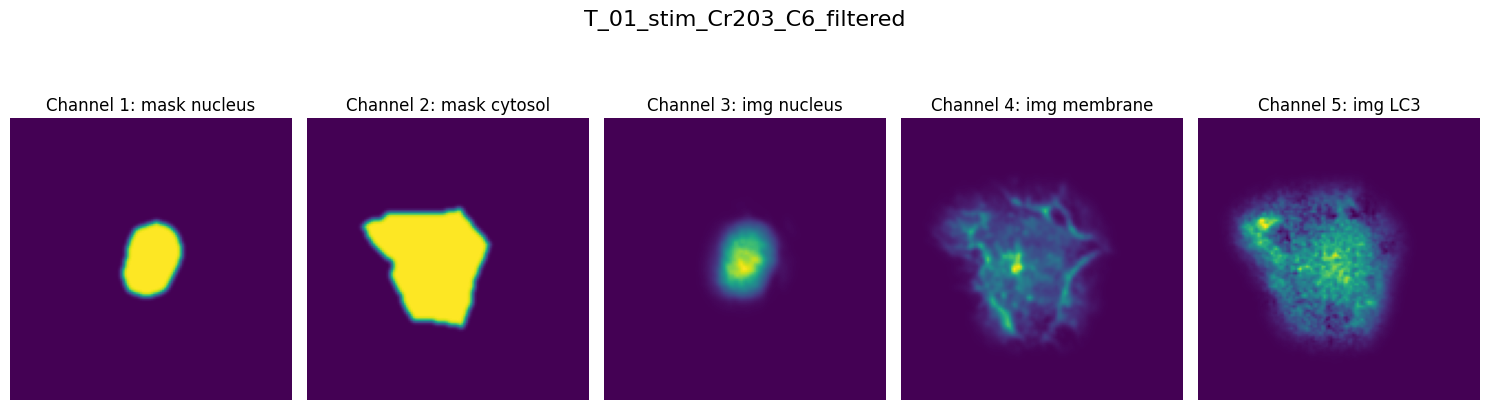

In [22]:
# Create a figure with subplots for each channel
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

# Loop through each channel and plot the image in the corresponding subplot
for channel in range(num_channels):
    axes[channel].imshow(stim_KO_cells_hdf5[0][channel])
    axes[channel].set_title(f"Channel {channel+1}: {channel_info[channel+1]}")
    axes[channel].axis('off')

# Adjust layout and spacing between subplots
plt.tight_layout()

# Add title
main_title = "T_01_stim_Cr203_C6_filtered"
plt.suptitle(main_title, fontsize=16, y=1.)

# Show the plot
plt.show()

In [23]:
#stim_wt
stim_wt_hdf5_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5"
stim_wt_hdf5 = h5py.File(stim_wt_hdf5_path, "r")
stim_wt_hdf5.keys()

stim_wt_index_hdf5 = stim_wt_hdf5["single_cell_index"][:]
stim_wt_cells_hdf5 = stim_wt_hdf5["single_cell_data"][0:100, :]

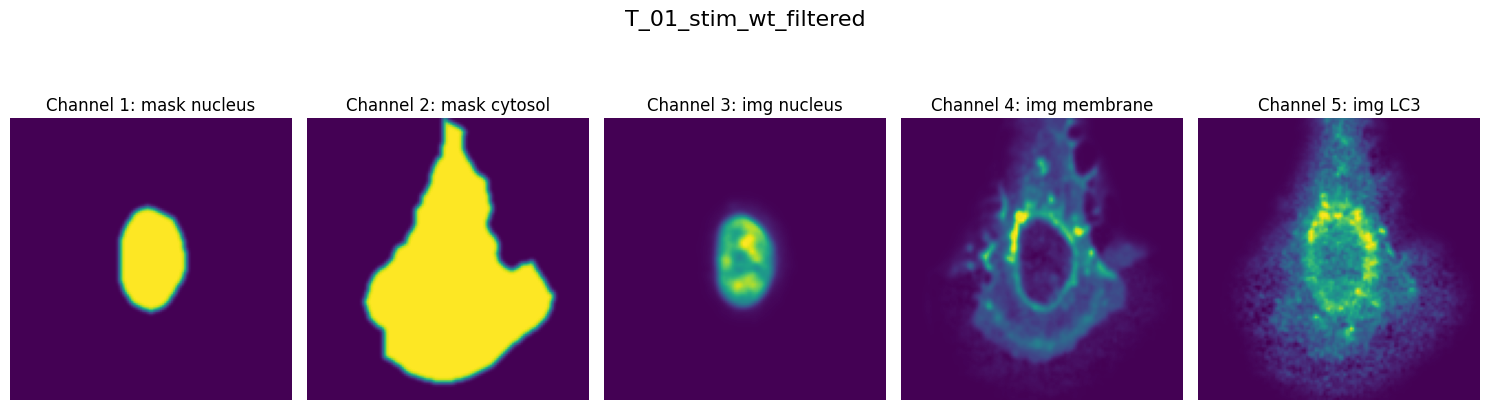

In [24]:
# Create a figure with subplots for each channel
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

# Loop through each channel and plot the image in the corresponding subplot
for channel in range(num_channels):
    axes[channel].imshow(stim_wt_cells_hdf5[0][channel])
    axes[channel].set_title(f"Channel {channel+1}: {channel_info[channel+1]}")
    axes[channel].axis('off')

# Adjust layout and spacing between subplots
plt.tight_layout()

# Add title
main_title = "T_01_stim_wt_filtered"
plt.suptitle(main_title, fontsize=16, y=1.)

# Show the plot
plt.show()

In [3]:
#unstim_wt
unstim_wt_hdf5_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5"
unstim_wt_hdf5 = h5py.File(unstim_wt_hdf5_path, "r")
unstim_wt_hdf5.keys()

unstim_wt_index_hdf5 = unstim_wt_hdf5["single_cell_index"][:]
unstim_wt_cells_hdf5 = unstim_wt_hdf5["single_cell_data"][0:100, :]

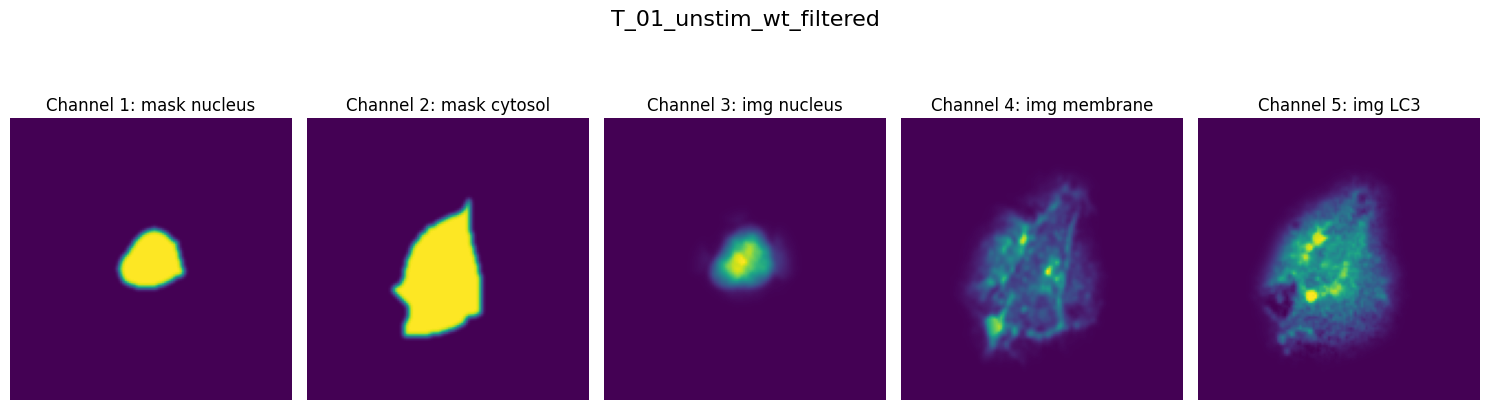

In [6]:
# Create a figure with subplots for each channel
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

# Loop through each channel and plot the image in the corresponding subplot
for channel in range(num_channels):
    axes[channel].imshow(unstim_wt_cells_hdf5[0][channel])
    axes[channel].set_title(f"Channel {channel+1}: {channel_info[channel+1]}")
    axes[channel].axis('off')

# Adjust layout and spacing between subplots
plt.tight_layout()

# Add title
main_title = "T_01_unstim_wt_filtered"
plt.suptitle(main_title, fontsize=16, y=1.)

# Show the plot
plt.show()

# II.  Retrain binary classifier from SPARCSpy and monitor performance with wandb <a class="anchor" id="sparcs"></a>

In [1]:
import os
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

from sparcscore.ml.datasets import HDF5SingleCellDataset
#from sparcscore.pipeline.project import TimecourseProject, Project
#from sparcscore.pipeline.workflows import MultithreadedWGATimecourseSegmentation, WGATimecourseSegmentation, MultithreadedCytosolCellposeTimecourseSegmentation, ShardedWGASegmentation, ShardedDAPISegmentationCellpose, WGASegmentation, DAPISegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction, TimecourseHDF5CellExtraction
from sparcscore.pipeline.classification import MLClusterClassifier
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

NOTE! Installing ujson may make loading annotations faster.


In [3]:
# Use HDF5 Data loader from SPARCSpy
hdf5_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_Cr203_filtered.h5', '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.X_stim_wt_filtered.h5'],
    dir_labels=[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],  # 0: Unstim wt (Autophagy intact), 1: Stim wt or Stim Cr203 (Autophagy not intact)
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 1200000
0: 700000
1: 500000


In [10]:
#print(len(hdf5_data))

sample = hdf5_data[0]
#print(sample[0].shape)
#print(sample[1])
#print(sample[2])

1200000
torch.Size([1, 128, 128])
tensor(1)
tensor(0)


In [11]:
sample = hdf5_data[0]
label = sample[1]
#print("Ground truth label:", label)

Ground truth label: tensor(1)


In [11]:
# Load the model architecture
model = autophagy_classifier2_1(device='cpu')

# Inspect the model architecture
print(model)

Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file src/pretrained_models/autophagy/autophagy2.1/VGG2_autophagy_classifier2.1.cpkt`


MultilabelSupervisedModel(
  (network): _VGG2(
    (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (softmax): LogSoftmax(dim=1)
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, k

Feature batch shape: torch.Size([900, 1, 128, 128])
Labels batch shape: torch.Size([900])


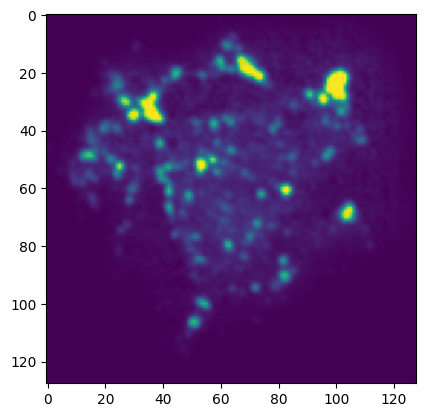

Label: 0


In [9]:
# Create a DataLoader for your HDF5SingleCellDataset

batch_size = 900 # batch size
data_loader = DataLoader(hdf5_data, batch_size=batch_size, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import wandb
import sys

# Redirect print statements to a file
sys.stdout = open("autophagy_output.txt", "w")

# Log into W&B
wandb.login()

# Start a W&B Run
run = wandb.init(project="VGG2_autophagy_subset_training")

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the autophagy classifier model on the selected device
model = autophagy_classifier2_1(device=device)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # number of training epochs
batch_size = 256  # batch size
log_interval = 100  # Log metrics every 100 batches

# Split the dataset into training and test sets (80% training, 20% test)
dataset_size = len(hdf5_data)
train_size = int(0.8 * dataset_size)

test_size = dataset_size - train_size
train_data, test_data = random_split(hdf5_data, [train_size, test_size])

# Create a DataLoader for the training set
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)  # No need to shuffle test data

stop_training = False

for epoch in range(1, num_epochs + 1):
    if stop_training:
        break  # Stop training if accuracy reaches 95%
    
    print("Epoch: ", epoch)
    model.train()  # Set the model to training mode
    
    total_loss = 0.0
    correct = 0
    
    total_samples = len(train_data)
    
    batch_counter = 0  # Reset batch counter at the start of each epoch

    for batch_idx, (data, labels) in enumerate(train_data_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        output = model(data)  # Forward pass
        loss = loss_function(output, labels)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(labels).sum().item()
        
        batch_counter += 1
        
        # Calculate accuracy and average loss for the current batch
        accuracy = 100.0 * correct / (batch_counter * batch_size)
        average_loss = total_loss / (batch_counter * batch_size)

        # Check for the desired accuracy and stop training if reached
        if accuracy >= 95.0:
            stop_training = True
            break

    # Calculate precision, recall, and F1-score for the entire training dataset at the end of the epoch
    all_train_labels = []
    all_train_predicted = []

    for data, labels in train_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predicted.extend(predicted.cpu().numpy())

    train_precision = precision_score(all_train_labels, all_train_predicted, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predicted, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predicted, average='macro')

    # Calculate training accuracy
    train_accuracy = accuracy_score(all_train_labels, all_train_predicted) * 100.0

    print("Train Precision: " + str(train_precision) + " Recall: " + str(train_recall) + " F1 score: " + str(train_f1))
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # Log train metrics for the epoch, including accuracy and loss
    wandb.log({
        "Train Epoch": epoch,
        "Train_Precision": train_precision,
        "Train_Recall": train_recall,
        "Train_F1-score": train_f1,
        "Train_Accuracy": train_accuracy,
        "Train_Loss": average_loss,
    })

    # Reset correct and total_loss at the beginning of each epoch
    correct = 0
    total_loss = 0.0

    # Evaluate the model on the test set after each epoch
    model.eval()
    test_correct = 0
    test_total_samples = len(test_data)
    test_average_loss = 0.0
    test_batch_counter = 0
    all_test_labels = []
    all_test_predicted = []

    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        test_correct += predicted.eq(labels).sum().item()
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predicted.extend(predicted.cpu().numpy())

        loss = loss_function(output, labels)
        test_average_loss += loss.item()
        test_batch_counter += 1

        # Calculate accuracy for the current test batch
        test_accuracy = 100.0 * test_correct / (test_batch_counter * batch_size)

        # Log test metrics for every 100 test batches
        if test_batch_counter % log_interval == 0:
            test_average_loss /= log_interval
            print("Test Accuracy: {:.2f}% Test Loss: {:.4f}".format(test_accuracy, test_average_loss))

            test_precision = precision_score(all_test_labels, all_test_predicted, average='macro')
            test_recall = recall_score(all_test_labels, all_test_predicted, average='macro')
            test_f1 = f1_score(all_test_labels, all_test_predicted, average='macro')

            # Log test metrics for every 100 test batches
            wandb.log({
                "Test Epoch": epoch,
                "Test_Batch": test_batch_counter,
                "Test_Loss": test_average_loss,
                "Test_Accuracy": test_accuracy,
                "Test_Precision": test_precision,
                "Test_Recall": test_recall,
                "Test_F1-score": test_f1,
            })
            test_average_loss = 0.0

    # Calculate precision, recall, and F1-score for the entire test dataset at the end of the epoch
    test_precision = precision_score(all_test_labels, all_test_predicted, average='macro')
    test_recall = recall_score(all_test_labels, all_test_predicted, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_predicted, average='macro')

    # Log test metrics for the entire test dataset at the end of the epoch
    wandb.log({
        "Test Epoch": epoch,
        "Test_Precision": test_precision,
        "Test_Recall": test_recall,
        "Test_F1-score": test_f1,
    })

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../workspace/SPARCSpy/src/pretrained_models/autophagy/autophagy2.1/VGG2_autophagy_classifier2.1.cpkt`


<b> What is being done here? <b>

* After a train (80%) and test (20%) split, accuracy, loss, precision, recall and F1 score values are looged on the test set at the end of each epoch.
* We are more interested in the performance of the test set and thus log the same metrics every 100 batches for each epoch as well as once at the end of an epoch. 
* Training is stopped as soon as accuracy reaches 95%.
* Logging happens on wandb. Results are also written to file.


<b> What did we see? <b>

We saw a good learning curve, and finally very high train and test set scores on wandb. Not many epochs were needed to reach this point.

<b> What does each metric do? <b>

* Accuracy shows model's performance in terms of correct predictions
* Loss is a measure of how well the model's predictions align with the actual data
* Precision tells us how well the classifier avoids false positives.
* Recall tells us how well the classifier captures all actual positives.
* F1 Score provides a balanced measure that considers both precision and recall.